In [2]:
import os
import cv2
import glob
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mtcnn import MTCNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [4]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [6]:
train = datagen.flow_from_directory(
    r"celebdf+ff++\train",
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

test = ImageDataGenerator(rescale=1./255).flow_from_directory(
    r"celebdf+ff++\test",
    target_size=(128, 128),
    batch_size=16,
    class_mode='binary'
)

Found 11633 images belonging to 2 classes.
Found 2400 images belonging to 2 classes.


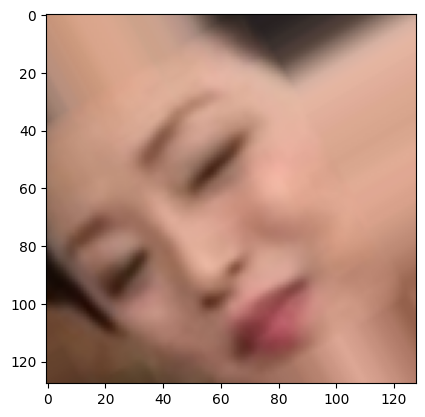

In [4]:
# Define CNN Model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification (Real vs Fake)
])

# Compile Model
model.compile(optimizer="Adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model Summary
model.summary()

c:\Users\jaiag\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callback = [EarlyStopping(monitor='val_loss',
                         patience=3,
                         verbose=1,
                         mode='auto',
                         restore_best_weights=True
                         ),
            ModelCheckpoint("best_model.h5", 
                            save_best_only=True, 
                            monitor="val_loss", 
                            mode="min", 
                            verbose=1
                            )
]

In [7]:
# Train Model
history = model.fit(train_real_datagen,
                    validation_data=test_real_datagen,
                    epochs=20,
                    verbose=1,
                    callbacks=callback
                    )

c:\Users\jaiag\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 142s 388ms/step - accuracy: 0.5137 - loss: 0.6964 - val_accuracy: 0.5000 - val_loss: 0.6936
Epoch 2/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 49s 136ms/step - accuracy: 0.5350 - loss: 0.6841 - val_accuracy: 0.6112 - val_loss: 0.6696
Epoch 3/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 50s 138ms/step - accuracy: 0.5803 - loss: 0.6684 - val_accuracy: 0.6767 - val_loss: 0.6390
Epoch 4/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 50s 136ms/step - accuracy: 0.5887 - loss: 0.6619 - val_accuracy: 0.6792 - val_loss: 0.5869
Epoch 5/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 49s 134ms/step - accuracy: 0.6250 - loss: 0.6471 - val_accuracy: 0.6771 - val_loss: 0.6140
Epoch 6/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 50s 137ms/step - accuracy: 0.6496 - loss: 0.6250 - val_accuracy: 0.7104 - val_loss: 0.5518
Epoch 7/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 50s 138ms/step - accuracy: 0.6819 - loss: 0.5986 - val_accuracy: 0.6829 - val_loss: 0.5904
Epoch 8/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 51s 139ms/step - accuracy: 0.6877 - loss: 

In [9]:
history = history.history

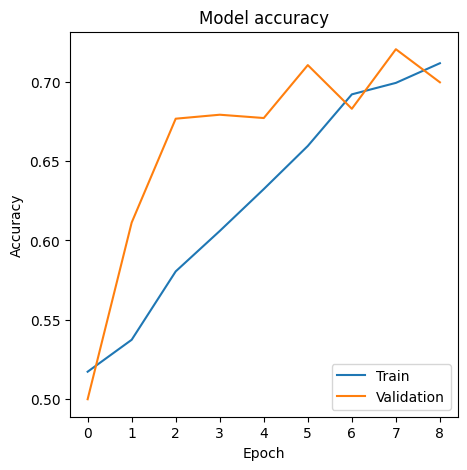

In [10]:
# FIRST
# Plot training & validation accuracy values
plt.figure(figsize=(5,5))
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

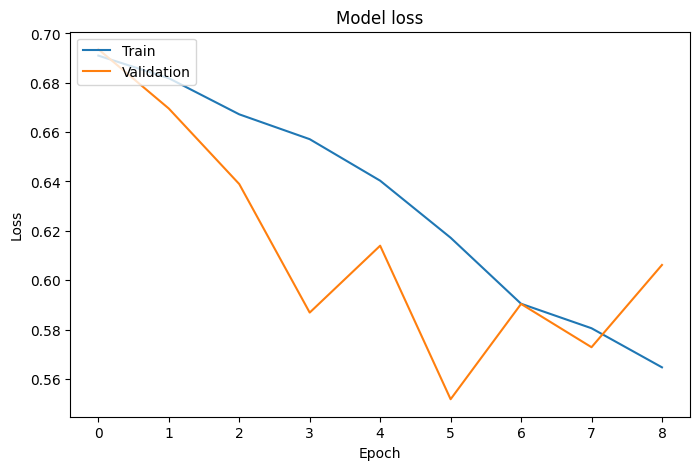

In [11]:
# FIRST
# Plot training & validation loss values
plt.figure(figsize=(8,5))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [3]:
model = load_model("best_model.h5")

150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step


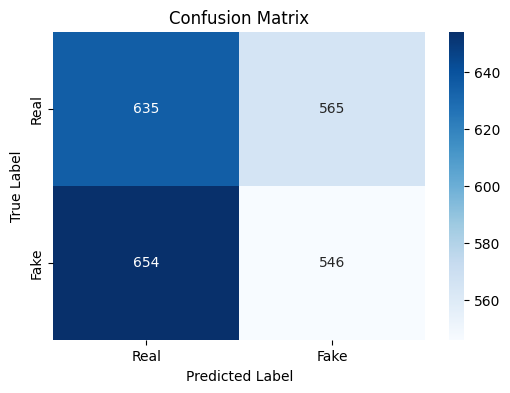

Classification Report:
               precision    recall  f1-score   support

        Real       0.49      0.53      0.51      1200
        Fake       0.49      0.46      0.47      1200

    accuracy                           0.49      2400
   macro avg       0.49      0.49      0.49      2400
weighted avg       0.49      0.49      0.49      2400



In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get True Labels
true_labels = test.classes  # Actual labels from test data

# Predict Probabilities
pred_probs = model.predict(test)
pred_labels = (pred_probs > 0.5).astype(int)  # Convert probabilities to binary (0 or 1)

# Compute Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
print("Classification Report:\n", classification_report(true_labels, pred_labels, target_names=["Real", "Fake"]))


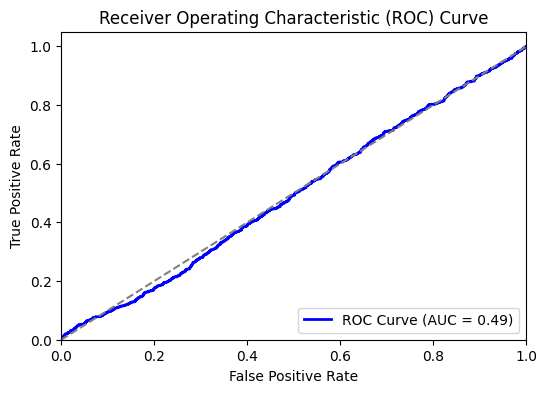

AUC Score: 0.4939


In [10]:
from sklearn.metrics import roc_curve, auc

# Compute ROC Curve
fpr, tpr, _ = roc_curve(true_labels, pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"AUC Score: {roc_auc:.4f}")


In [191]:
def predict_image(img_path):
    img = cv2.imread(img_path)
    # img = cv2.resize(img, (128, 128))  # Resize
    img = img / 255.0  # Normalize (0-1)
    img = img.astype(np.float32)

    # Add a batch dimension
    img = np.expand_dims(img, axis=0)


    predictions = model.predict(img)
    # avg_prediction = np.mean(predictions)  # Average across all frames
    print(f"Prediction Score: {predictions}")
    print(f"Final Classification: {"Fake" if predictions  < 0.45 else "Real"}")
    return predictions

In [192]:
predict_image(r"celebdf+ff++\train\real\129_6.png")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Prediction Score: [[0.9989441]]
Final Classification: Real


array([[0.9989441]], dtype=float32)

In [74]:
count = 0
for i in os.listdir(r"celebdf+ff++\test\real"):
    img = cv2.imread(os.path.join(r"celebdf+ff++\test\real", i))
    img = img / 255.0
    img = img.astype(np.float32)
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    if pred < 0.5:
        print("real")
        count += 1
print(count)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/st

In [75]:
len(os.listdir(r"celebdf+ff++\test\real"))

1200

In [77]:
count = 0
for i in os.listdir(r"celebdf+ff++\test\fake"):
    img = cv2.imread(os.path.join(r"celebdf+ff++\test\fake", i))
    img = img / 255.0
    img = img.astype(np.float32)
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    if pred < 0.5:
        print("real")
        count += 1
print(count)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

In [169]:
# Function to extract frames from video provided by user
def extract_frames(video_path, frame_interval=5):
    detector = MTCNN()
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0
    ret, frame = cap.read()
    while ret:
        if frame_count % frame_interval == 0:
            faces = detector.detect_faces(frame)
            if len(faces) != 0:
                x, y, width, height = faces[0]['box']
                frame = frame[y:y + height, x:x + width]
                frame = cv2.resize(frame, (128, 128))
                frame = frame / 255.0  # Normalize
                frame = np.expand_dims(frame, axis=0)
                frames.append(frame)
                # print(frame_count)
        ret, frame = cap.read()
        frame_count += 1

    cap.release()
    frames = np.array(frames)
    print(f"Total Frames: {len(frames)}")

    return frames

In [171]:
type(frames)

numpy.ndarray

In [186]:
def predict_video(video_path):
    frames = extract_frames(video_path)
    plt.imshow(frames[0][0])
    predictions = []
    for frame in frames:
        pred = model.predict(frame,verbose=0)
        predictions.append(pred)
    avg_prediction = np.mean(predictions)  # Average across all frames
    print(f"Average Prediction Score: {avg_prediction:.4f}")

    # If avg_prediction > 0.5, classify as Fake; else, Real
    video_label = "Fake" if avg_prediction < 0.5 else "Real"
    print(f"Final Video Classification: {video_label}")

Total Frames: 17
Average Prediction Score: 0.3772
Final Video Classification: Fake


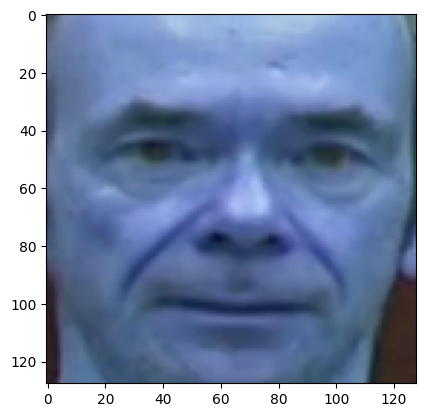

In [188]:
predict_video(r"C:\Users\jaiag\Desktop\Postulate\DeepfakeTIMIT\DeepfakeTIMIT\higher_quality\mmdm2\sa2-video-mccs0.avi")

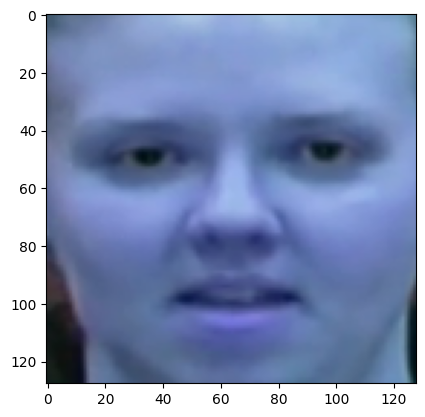

In [105]:
plt.imshow(frames[17])